In [ ]:
#I was getting different learning curves all the time and after researching how to fix this issue I came up with the following solution:
import os
import numpy as np
import random as rn 
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [1]:

def loadCsv(fileName):
    import pandas as pd
    import io

    directory = os.getcwd()                                    #gets curremt directory
    file1 = os.path.join(directory, fileName)                  #joins directory path with filename
   
    df = pd.read_csv(file1, header=None, skiprows=1)           #read file as a data frame    
    return df


In [2]:
def omitNan(df):
    
    list1 = df.to_numpy()                        #convert data frame to numpy array (2D)
    flat = list1.ravel()                         #flattens the array
    condensedList=[]
    
    
    for i in range(len(flat)):
        x=flat[i]
        if pd.notna(x):                           # True for real values, False for NaN
            condensedList.append(x)
    condensedList = np.array(condensedList)
    condensedDf = pd.DataFrame(condensedList)
    return condensedList, condensedDf

In [3]:
import numpy as np
def countUniqueItems(df):
    
    condensedList, condensedDf = omitNan(df)                   #omitNan returns a flattened numpy array
   
    uniqueItems = np.unique(condensedList)
    return len(uniqueItems)
    
    

In [4]:
def mostFrequent (df):
    list1, condensedDf = omitNan(df)
    
    flat = list1.flatten()


    values, counts = np.unique(flat, return_counts=True)


    i = np.argmax(counts)
    mostFreq = values[i]
    
    return mostFreq

In [5]:
#Convert data frame to list of lists and returns it
def convertDataFrame(df):
    import pandas as pd
   
    transactions = []

    for i in range(len(df)):
        row = df.iloc[i]                # get the row as a Series
        row = row.dropna()              # drop NaN values
        itemList = row.tolist()         # convert to Python list
        transactions.append(itemList)      # add the list to transactions

    return transactions
        

In [6]:

def generateRules(df):
    import pandas as pd
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import fpgrowth, association_rules



    dataset = convertDataFrame(df)
    te = TransactionEncoder()
    te2 = te.fit(dataset).transform(dataset)
    df2 = pd.DataFrame(te2, columns=te.columns_)

    frequentItemSets = fpgrowth(df2, min_support=0.01, use_colnames=True)
    print("Length of frequent items ", len(frequentItemSets))
    rules = association_rules(frequentItemSets, metric="confidence", min_threshold=0.08)

    return rules


In [7]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

def countRules(df, minSupport, minConfidence):
        
    transactions = convertDataFrame(df)
    
    # Encode transactions for mlxtend
    te = TransactionEncoder()
    te2 = te.fit(transactions).transform(transactions)
    dfEncoded = pd.DataFrame(te2, columns=te.columns_)
    
    
    frequentItemsets = fpgrowth(dfEncoded, min_support=minSupport, use_colnames=True)
    
    
    rules = association_rules(frequentItemsets, metric="confidence", min_threshold=minConfidence)
    
    return len(rules), frequentItemsets

In [8]:
df=loadCsv("Grocery_Items_1.csv")
condensedList, condensedDf=omitNan(df)
countUnique=countUniqueItems(df)

print("Unique Items\t",countUnique)
print("Items in dataframe not including Nan\t", len(condensedList))
mostFreq= mostFrequent(df)
print("Most Frequent Item \t",mostFreq)

transactions = convertDataFrame(df)


#print(transactions)


Unique Items	 165
Items in dataframe not including Nan	 20690
Most Frequent Item 	 whole milk


In [9]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder



rules = generateRules(df)

print(rules)


Length of frequent items  69
          antecedents         consequents  antecedent support  \
0              (soda)        (whole milk)            0.100500   
1              (soda)  (other vegetables)            0.100500   
2  (other vegetables)              (soda)            0.120375   
3  (other vegetables)        (whole milk)            0.120375   
4        (whole milk)  (other vegetables)            0.157000   
5        (rolls/buns)  (other vegetables)            0.111000   
6  (other vegetables)        (rolls/buns)            0.120375   
7        (rolls/buns)        (whole milk)            0.111000   
8        (whole milk)        (rolls/buns)            0.157000   
9            (yogurt)        (whole milk)            0.086625   

   consequent support   support  confidence      lift  representativity  \
0            0.157000  0.011625    0.115672  0.736762               1.0   
1            0.120375  0.010375    0.103234  0.857602               1.0   
2            0.100500  0.01037

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

minSupport = [0.001, 0.005, 0.01]
minConfidence = [0.05, 0.075, 0.1]

# Because the heatmap needs a 2D array
ruleCounts = np.zeros((len(minConfidence), len(minSupport)))

# Just to inspect what countRules returns
result = countRules(df, minSupport[0], minConfidence[0])
print(result, type(result))

for i in range(len(minConfidence)):
    for j in range(len(minSupport)):
        
        ruleCounts[i, j] = countRules(df, minSupport[j], minConfidence[i])[0]
        x = 0  


(522,       support                         itemsets
0    0.057500                  (bottled water)
1    0.039250                     (newspapers)
2    0.015500                    (hard cheese)
3    0.069250                (root vegetables)
4    0.035000                         (butter)
..        ...                              ...
804  0.001000  (other vegetables, chewing gum)
805  0.001375  (canned vegetables, whole milk)
806  0.001250        (canned fish, whole milk)
807  0.001125        (rolls/buns, canned fish)
808  0.001000            (canned fish, yogurt)

[809 rows x 2 columns]) <class 'tuple'>


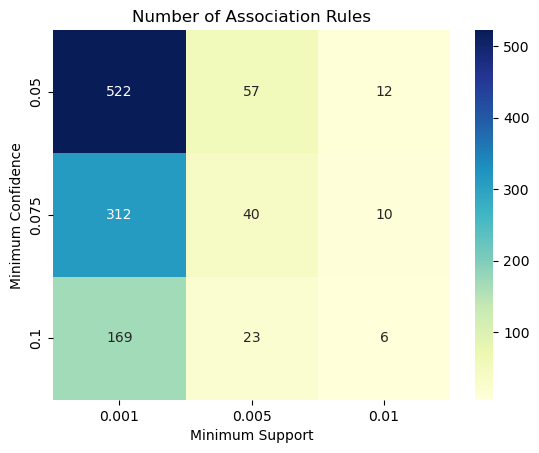

In [12]:
sns.heatmap(ruleCounts, annot=True, fmt=".0f", xticklabels=minSupport, yticklabels=minConfidence, cmap="YlGnBu")
plt.xlabel("Minimum Support")
plt.ylabel("Minimum Confidence")
plt.title("Number of Association Rules")
plt.show()

In [13]:
import warnings
warnings.filterwarnings('ignore')

def learningCurve(history):
   
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [14]:
import tensorflow as tf
import numpy as np
import os

base_path = os.getcwd()  # current working directory
print (base_path)
train_dir = os.path.join(base_path, "Assignment3", "Covid19-dataset", "train")
print(train_dir, os.path.exists(train_dir))

2025-11-26 13:12:50.578184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/eaeba168-bf0d-4360-b850-e08069ec103a/Assignment3
/home/eaeba168-bf0d-4360-b850-e08069ec103a/Assignment3/Assignment3/Covid19-dataset/train False


In [15]:

import tensorflow as tf
import os
import numpy as np

directory = os.getcwd()                                    #gets curremt directory
trainDir = os.path.join(directory, "Covid19-dataset", "train")
testDir = os.path.join(directory, "Covid19-dataset", "test")





In [16]:

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
import os
import numpy as np

trainDataset = image_dataset_from_directory( 
    trainDir,
    labels='inferred',
    label_mode='categorical', 
    image_size=(128, 128),
    batch_size=32,
    shuffle=True, 
    validation_split=0.2,
    subset = 'training',
    seed = 123
)

validationDataset = image_dataset_from_directory(
    trainDir,
    labels='inferred',
    label_mode='categorical',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset = 'validation',
    seed = 123
)
testDataset = image_dataset_from_directory(
    testDir, 
    image_size=(128, 128), batch_size=32, labels='inferred', label_mode='categorical', shuffle=False
    
)



Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.


2025-11-26 13:14:20.810575: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [17]:
def normalize_datasets(trainDataset, validationDataset, testDataset):
    normalization_layer = Rescaling(1./255)
    trainDataset = trainDataset.map(lambda x, y: (normalization_layer(x), y))
    validationDataset = validationDataset.map(lambda x, y: (normalization_layer(x), y))
    testDataset = testDataset.map(lambda x, y: (normalization_layer(x), y))
    return trainDataset, validationDataset, testDataset



In [18]:
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

trainDataset, validationDataset, testDataset = normalize_datasets(trainDataset, validationDataset, testDataset)

inputShape = (128, 128, 3)

model = keras.Sequential(
    [
        keras.Input(shape=inputShape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ]
)

model.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dropout (Dropout)           (None, 57600)             0

In [19]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(
    trainDataset,  # Training dataset
    epochs=20,  # 20 epochs (can adjust if necessary)
    #validation_data=validationDataset to model.fit)
    validation_data=validationDataset,  # Validation dataset
    batch_size=32  # Batch size (can adjust based on available resources)
)

Epoch 1/20


2025-11-26 13:14:52.931416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [201]
	 [[{{node Placeholder/_0}}]]
2025-11-26 13:14:52.931840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [201]
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.4527

2025-11-26 13:14:58.941189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [50]
	 [[{{node Placeholder/_4}}]]
2025-11-26 13:14:58.950827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 7s 531ms/step - loss: 1.1252 - accuracy: 0.4527 - val_loss: 0.6866 - val_accuracy: 0.7000
Epoch 2/20
7/7 [==============================] - 11s 844ms/step - loss: 0.6221 - accuracy: 0.7761 - val_loss: 0.3399 - val_accuracy: 0.9400
Epoch 3/20
7/7 [==============================] - 5s 388ms/step - loss: 0.3857 - accuracy: 0.8706 - val_loss: 0.1290 - val_accuracy: 0.9800
Epoch 4/20
7/7 [==============================] - 5s 462ms/step - loss: 0.2518 - accuracy: 0.8955 - val_loss: 0.1479 - val_accuracy: 0.9200
Epoch 5/20
7/7 [==============================] - 5s 499ms/step - loss: 0.2830 - accuracy: 0.8905 - val_loss: 0.1126 - val_accuracy: 0.9600
Epoch 6/20
7/7 [==============================] - 5s 409ms/step - loss: 0.2436 - accuracy: 0.8955 - val_loss: 0.1620 - val_accuracy: 0.9600
Epoch 7/20
7/7 [==============================] - 5s 404ms/step - loss: 0.1564 - accuracy: 0.9453 - val_loss: 0.0696 - val_accuracy: 0.9800
Epoch 8/20
7/7 [==============

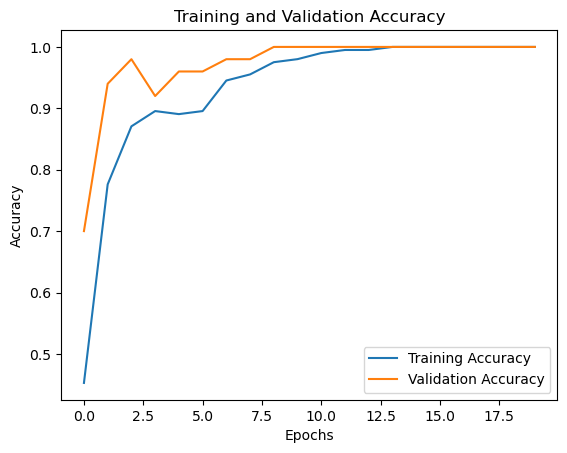

In [20]:
learningCurve(history)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 8)         2312      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dropout_1 (Dropout)         (None, 7200)             

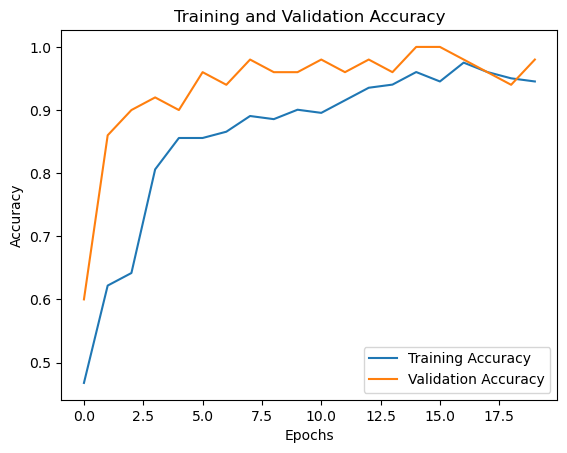

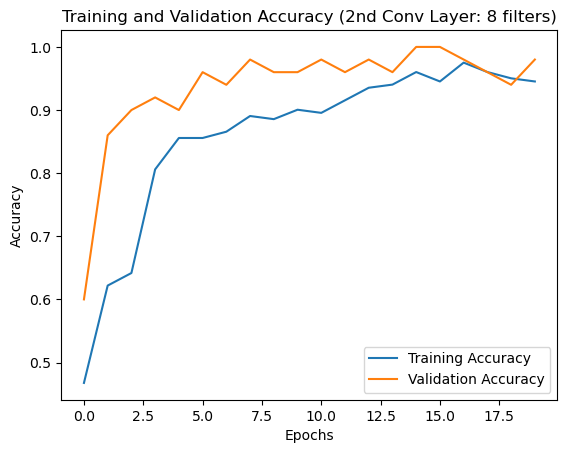

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Keep input shape and first Conv2D layer unchanged
input_shape = (128, 128, 3)

model8Filters = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # First Conv2D unchanged
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(8, (3, 3), activation='relu'),  # Only 2nd Conv layer changed to 8 filters
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),                            # Keep Dropout same as original
    layers.Dense(3, activation='softmax')          # Output layer unchanged
])

# Compile using the same optimizer and parameters as original
model8Filters.compile(optimizer=Adam(),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

model8Filters.summary()

# Train the model
history8Filters= model8Filters.fit(
    trainDataset,
    validation_data=validationDataset,
    epochs=20
)

# Plot the learning curve
learningCurve(history8Filters)
plt.plot(history8Filters.history['accuracy'], label='Training Accuracy')
plt.plot(history8Filters.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (2nd Conv Layer: 8 filters)')
plt.legend()
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 14400)             0         
                                                                 
 dropout_2 (Dropout)         (None, 14400)            

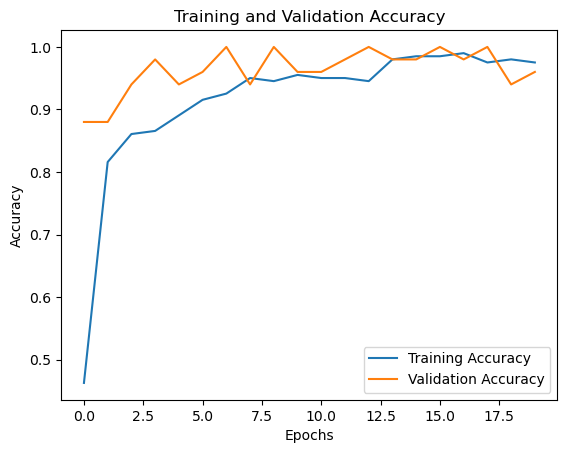

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


inputShape = (128, 128, 3)

# Model with 16 filters in the second Conv2D layer
model16Filters = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape),  
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),  # 2nd Conv layer with 16 filters
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Keep Dropout same as original
    layers.Dense(3, activation='softmax')  # Output layer unchanged
])

# Compile the model using the same optimizer and parameters as the original
model16Filters.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model16Filters.summary()

# Train the model (using your existing trainDataset and validationDataset)
history16Filters = model16Filters.fit(
    trainDataset, validation_data=validationDataset, epochs=20
)

learningCurve(history16Filters)
# Plot the learning curve
#plt.plot(history16Filters.history['accuracy'], label='Training Accuracy (16 filters)')
#plt.plot(history16Filters.history['val_accuracy'], label='Validation Accuracy (16 filters)')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy (2nd Conv Layer: 16 filters)')
#plt.legend()
#plt.show()

In [23]:
#Text Classification Task

from datasets import load_dataset
from pprint import pprint

dataFiles = {
    "train": "train.json",
    "validation": "validation.json",
    "test": "test.json"
}

dataset = load_dataset("json", data_files=dataFiles)    #reads each JSON file and converts it into a Dataset object

# Check the dataset
print(dataset)
pprint(dataset['train'][0])


DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 400
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1500
    })
})
{'ID': '2017-En-10588',
 'Tweet': "@Daniel_Sankey @hayleyp79 Haha.... Actually, after the Doggies I'm "
          'barracking for Anyone But GWS! ',
 'anger': False,
 'anticipation': False,
 'disgust': False,
 'fear': False,
 'joy': True,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': False}


In [24]:
#Data Preprocessing. Note: had to switch to distilbert due to cloud service constrains :
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 
          'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

id2label = {}
for i, label in enumerate(labels):             #enumerate() takes a list and returns pairs of (index, value).
    
    id2label[i] = label                        #Creates a dictionary where the key is the index and the value is the label.

print(id2label)

label2id = {}
for i, label in enumerate(labels):             #Creates a dictionary where the key is the label and the value is the index.
       
    label2id[label] = i

print(label2id)

{0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear', 4: 'joy', 5: 'love', 6: 'optimism', 7: 'pessimism', 8: 'sadness', 9: 'surprise', 10: 'trust'}
{'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'love': 5, 'optimism': 6, 'pessimism': 7, 'sadness': 8, 'surprise': 9, 'trust': 10}


In [25]:
import numpy as np

def preprocessData(examples):
    text = examples["Tweet"]
#    encoding = tokenizer(text, padding="max_length", truncation=True,max_length=128)
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=64)

    
    #Add labels
    rows = len(examples["Tweet"])   
    cols = len(labels)     

    labelsMatrix = np.zeros((rows, cols))
    print(labelsMatrix.shape)  

    for j in range(cols):
        labelName = labels[j]
        for i in range(rows):
            labelsMatrix[i, j] = int(examples[labelName][i])
     
    encoding["labels"] = labelsMatrix.tolist()
    
    return encoding

In [26]:
encodedDataset = dataset.map(preprocessData,  batched=True,  remove_columns=dataset['train'].column_names  )

example = encodedDataset['train'][0]
print(example['labels'])             # multi-hot vector
print(tokenizer.decode(example['input_ids']))  # reconstructs the tweet

Map: 100%|██████████| 400/400 [00:00<00:00, 4379.63 examples/s]

(400, 11)
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[CLS] @ daniel _ sankey @ hayleyp79 haha.... actually, after the doggies i ' m barracking for anyone but gws! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [27]:
from transformers import AutoModelForSequenceClassification

numLabels = 11

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=numLabels,
    problem_type="multi_label_classification"
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert-multilabel",       
    num_train_epochs=3,                   # reduced epochs for testing / to prevent crashes
    per_device_train_batch_size=4,        # smaller batch size to reduce memory usage
    per_device_eval_batch_size=4,
    logging_dir="./logs",
    logging_steps=5,                      
    learning_rate=2e-5,
    eval_strategy="epoch",                # evaluate after each epoch
    save_strategy="epoch",                # save model after each epoch
    load_best_model_at_end=True,
    report_to="none"                      
)

In [29]:
import numpy as np

def compute_metrics(evalPred):
    logits, labels = evalPred
    preds = (logits > 0).astype(int)     # convert logits → predicted labels

    # exact-match accuracy (all 11 labels must match)
    accuracy = (preds == labels).all(axis=1).mean()

    return {"accuracy": accuracy}

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encodedDataset["train"],
    eval_dataset=encodedDataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.339900,0.332172,0.260000
2,0.304000,0.312501,0.267500
3,0.307000,0.312701,0.297500


TrainOutput(global_step=2250, training_loss=0.33069569799635146, metrics={'train_runtime': 3646.9034, 'train_samples_per_second': 2.468, 'train_steps_per_second': 0.617, 'total_flos': 149049742464000.0, 'train_loss': 0.33069569799635146, 'epoch': 3.0})

In [31]:
testResults = trainer.evaluate(encodedDataset["test"])
print(testResults)


{'eval_loss': 0.3130524456501007, 'eval_accuracy': 0.25933333333333336, 'eval_runtime': 81.0695, 'eval_samples_per_second': 18.503, 'eval_steps_per_second': 4.626, 'epoch': 3.0}


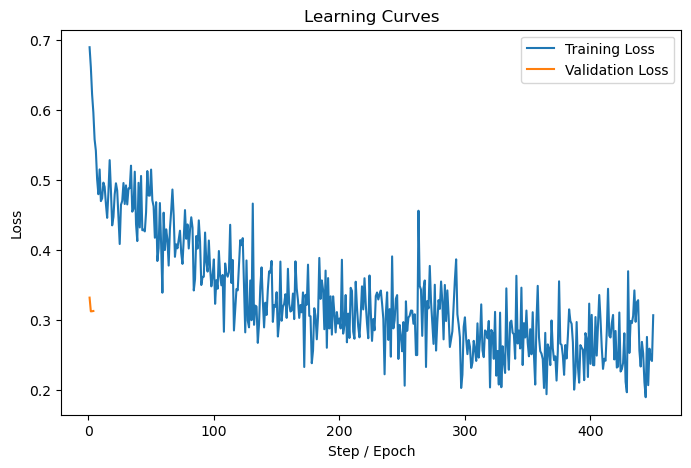

In [32]:
import matplotlib.pyplot as plt

# Extract logs
trainLosses = []
valLosses = []

logs = trainer.state.log_history
for i in range(len(logs)):
    if "loss" in logs[i]:
        trainLosses.append(logs[i]["loss"])
    if "eval_loss" in logs[i]:
        valLosses.append(logs[i]["eval_loss"])

# x-axis
trainSteps = list(range(1, len(trainLosses) + 1))
valSteps = list(range(1, len(valLosses) + 1))

# Plot
plt.figure(figsize=(8,5))
plt.plot(trainSteps, trainLosses, label="Training Loss")
plt.plot(valSteps, valLosses, label="Validation Loss")
plt.xlabel("Step / Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()


In [ ]:
import numpy as np
from transformers import EvalPrediction

def exactAccuracy(pred):
    logits = pred.predictions       # instead of unpacking
    labels = pred.label_ids

    probs = 1 / (1 + np.exp(-logits))        # Apply sigmoid 
    preds = (probs >= 0.5).astype(int)       # Threshold probabilities

    matches = (preds == labels).all(axis=1)
    return {"accuracy": np.mean(matches)}



In [ ]:
# Redefine the trainer with your custom metric
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encodedDataset["train"],
    eval_dataset=encodedDataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=exactAccuracy   # set it here
)

# Evaluate on the test dataset
testResults = trainer.evaluate(encodedDataset["test"], metric_key_prefix="test")
print(testResults)


In [ ]:
import numpy as np

def atLeastOneLabelAccuracy(pred):
    logits, labels = pred
    
    
    probs = 1 / (1 + np.exp(-logits))                       # Apply sigmoid to get probabilities
    
    
    preds = (probs >= 0.5).astype(int)                     # Convert probabilities to binary predictions

    #-------------------------------------------------
    # Make sure labels are integers too
    labels_int = labels.astype(int)

    # Count as correct if at least one label matches
    matches = (preds & labels_int).any(axis=1)


    #--------------------------------------
    # Count as correct if at least one label matches
    #matches = (preds & labels).any(axis=1)   # bitwise AND, then any
    # Compute the mean of matches
    accuracyValue = np.mean(matches)


    accuracyDict = {"accuracy": accuracyValue}


    return accuracyDict

    



In [ ]:

trainer.compute_metrics = atLeastOneLabelAccuracy

# Evaluate on test dataset using this metric
testResultsLenient = trainer.evaluate(
    encodedDataset["test"], 
    metric_key_prefix="test_lenient"
)

print(testResultsLenient)


In [ ]:
{
  'test_lenient_loss': 0.362,
  'test_lenient_accuracy': 0.703,
  'test_lenient_runtime': 81.56,
  'test_lenient_samples_per_second': 18.39,
  'test_lenient_steps_per_second': 4.60
}


In [ ]:
from pathlib import Path
import shutil

# Path to Hugging Face cache
cache_dir = Path.home() / ".cache/huggingface/transformers"

# Check if it exists
if cache_dir.exists():
    # Remove all contents
    shutil.rmtree(cache_dir)
    print(f"Cleared Hugging Face cache at {cache_dir}")
else:
    print(f"No cache found at {cache_dir}")


In [42]:
import os
from pathlib import Path

# Get the cache location from environment variables
# It defaults to ~/.cache/huggingface if the variable isn't explicitly set
hf_cache_home = os.environ.get("HF_HOME", Path.home() / ".cache/huggingface")

print(f"Hugging Face cache is located at: {hf_cache_home}")


Hugging Face cache is located at: /home/eaeba168-bf0d-4360-b850-e08069ec103a/.cache/huggingface
